In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os.path import join
from os import listdir
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import sklearn
data_path = join('drive', 'MyDrive', 'Project', 'Data')
full_df = pd.read_csv(join(data_path, 'final_dataset.csv'))

In [ ]:
translated_path = join(data_path, 'texts_translated')
translated = pd.concat([pd.read_csv(join(translated_path, name)) for name in sorted(listdir(translated_path))], ignore_index=True)

In [ ]:
reduced = translated[['id', 'story', 'lang']].copy()
reduced.loc[:,'story'] = reduced['story'].apply(lambda x :len(x) if type(x)==str else 0)

In [ ]:
full_df = pd.merge(full_df, reduced, on='id')

Preprocessing variables

In [ ]:
def fun(j):
    return list(set(re.findall(r'\'(\b\w+\b)\'', j) + list(map(lambda x: x[0]+" " +x[1], re.findall(r"\"(\w+).*?(\w \w+)\"", j)))))
data = full_df.copy()
data = data[data['state'].isin(['successful', 'failed'])]
data.loc[:, 'category'] = data['category'].apply(fun)
data.loc[:, 'sub_category'] = data['sub_category'].apply(fun)

data.loc[:, 'duration'] = data['deadline']-data['launched_at']
data.loc[:, 'usd_goal'] = data['goal']*data['fx_rate']
data.loc[:, 'state'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
data = data[data['usd_pledged'] >= 1]
data = data[data['usd_pledged'] <= 2*1e6]
data = data[data['lang'] != 'unknown']
data = data[data['story'] >= 50]
data = data.drop(columns=['id', 'project_url', 'image', 'fx_rate', 'launched_at', 'deadline', 'goal'])
data = data.dropna(axis = 0, how ='any')

weekday = {'Mon':1, 'Tue':2, 'Wed':3, 'Thu':4, 'Fri':5, 'Sat':6, 'Sun':7}
month = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 
         'June':6, 'July':7, 'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
data.loc[:, 'Launch_Week'] = data['Launch_Week'].apply(lambda x: weekday[x])
data.loc[:, 'Deadline_Week'] = data['Deadline_Week'].apply(lambda x: weekday[x])
data.loc[:, 'Launch_Month'] = data['Launch_Month'].apply(lambda x: month[x])
data.loc[:, 'Deadline_Month'] = data['Deadline_Month'].apply(lambda x: month[x])

In [ ]:
### One Hot Encoding of Category

# one_hot = set([cat for l in data.category for cat in l])
# one_hot_dict = {cat:[] for cat in one_hot}
# for i, cats in enumerate(data.category):
#   for cat in set(cats):
#     one_hot_dict[cat].append(1)
#   for cat in one_hot.difference(set(cats)):
#     one_hot_dict[cat].append(0)
# cat_df = pd.DataFrame(one_hot_dict, index=data.index)
# data[cat_df.columns] = cat_df 
# data = data.drop(columns=['category'])

# Dealing with categorical variables

Target encoding and weight of evidence for regression and classification targets is used, after splitting train and test

In [ ]:
columns = ['Launch_Day', 'duration', 'n_gifs', 'n_websites', 'Deadline_Day',
       'historic_pc2', 'historic_pc0', 'historic_pc3', 'historic_pc4', 'creator_bio', 'Deadline_Week',
       'Launch_Week', 'tiers_values_std', 'category',
       'disable_communication', 'country', 'sub_category','has_video', 'usd_pledged', 'state', 'lang']
        # + [col for col in data.columns if 'text' in col]
reg_data = data[columns]

In [ ]:
X, y_class, y_reg = [reg_data.drop(columns=['usd_pledged', 'state']), reg_data.state, reg_data.usd_pledged]

The problem with our categorical variables is that they are lists of categories, not just plain categories, so we have to find the indices of projects that contain each single category, average pledge amounts and compute success rate for each category, and then embed each list of categories as the average of the scores relative to each single category.

In [ ]:
def weighted_avg(vector):
  '''
  vector is a binary [0,1] vector, so the mean corresponds to the success
  frequency, and 1-mean is the failure frequency
  '''
  n = len(vector)
  if n>0:
    avg = np.mean(vector)
    # log_odd = np.log(np.mean(vector)/(1-np.mean(vector))) if np.mean(vector)<0.9 else np.log(10)
    return (n, avg)
  else:
    return (0,0)

class CategoricalEmbeddings():
  def __init__(self, feature_names: list):
    self.categorical_features = feature_names
    
  
  def fit(self, X, y_class=None, y_reg=None):
    self.embeddings = dict()
    arr = X[self.categorical_features].copy()
    self.reg = y_reg is not None
    self.clas = y_class is not None
    
    for categorical in self.categorical_features:
      
      if type(X[categorical].iloc[0]) == list:  
        cats = set([cat for l in X[categorical] for cat in l])
        indices = {cat:[] for cat in cats}
        for i, row in arr[categorical].iteritems():
          for cat in row:
            indices[cat].append(i)
        # each category is represented by a tuple with the odds of success and the average
        # pledged amount of projects belonging to the category (in this order)
        if self.reg and self.clas:
          self.embeddings[categorical] = {cat:(weighted_avg(y_class.loc[indices[cat]]),y_reg.loc[indices[cat]].mean()) for cat in cats}
        elif self.clas:
          self.embeddings[categorical] = {cat:weighted_avg(y_class.loc[indices[cat]]) for cat in cats}
        elif self.reg:
          self.embeddings[categorical] = {cat:y_reg.loc[indices[cat]].mean() for cat in cats}
        else:
          print('Target Variable missing')
      
      elif type(X[categorical].iloc[0]) == str:
        cats = set([cat for cat in X[categorical]])
        indices = {cat:[] for cat in cats}
        for i, cat in arr[categorical].iteritems():
          indices[cat].append(i)      
        if self.reg and self.clas:
          self.embeddings[categorical] = {cat:(weighted_avg(y_class.loc[indices[cat]]),y_reg.loc[indices[cat]].mean()) for cat in cats}
        elif self.clas:
          self.embeddings[categorical] = {cat:weighted_avg(y_class.loc[indices[cat]]) for cat in cats}
        elif self.reg:
          self.embeddings[categorical] = {cat:y_reg.loc[indices[cat]].mean() for cat in cats}
        else:
          print('Target Variable missing')



  def fit_transform(self, X, y_class=None, y_reg=None):
    self.fit(X=X, y_class=y_class, y_reg=y_reg)
    return self.transform(X)


  def transform(self, X):
    if self.reg and self.clas:
      return self._transform_both(X)
    elif self.clas:
      return self._transform_class(X)
    elif self.reg:
      return self._transform_reg(X)
    else:
      print('Target Variable missing')
      return None

  def _transform_both(self, X):
    X_copy = X.copy()
    for categorical in self.categorical_features:
      embeddings = self.embeddings[categorical]
      cat_pledged = []
      combined_odds = []
      for i, row in X_copy[categorical].iteritems():
        if type(row) == list:
          pledged = 0
          odds = 0
          lens = []
          for cat in row:
            try:
              n = embeddings[cat][0][0]
              log_odd = embeddings[cat][0][1]
              lens.append(n)
              odds += n*log_odd
              pledged += n*embeddings[cat][1]   
            except:
              print(f'Found new key {cat} not seen in fit')
          avg_pledged = pledged/sum(lens) if len(lens) else 0
          combine_odds = odds/sum(lens) if len(lens) else 0
          cat_pledged.append(avg_pledged)
          combined_odds.append(combine_odds)
        elif type(row) == str:
          try:
            combined_odds.append(embeddings[row][0][1])
            cat_pledged.append(embeddings[row][1])
            
          except:
            print(f'Found new key {row} not seen in fit')
            cat_pledged.append(0)
            combined_odds.append(0)
      X_copy.loc[:, f'{categorical}_pledged'] = cat_pledged
      X_copy.loc[:, f'{categorical}_odds'] = combined_odds 
      X_copy = X_copy.drop(columns=[categorical])
    return X_copy

  def _transform_class(self, X):
    X_copy = X.copy()
    for categorical in self.categorical_features:
      embeddings = self.embeddings[categorical]
      combined_odds = []
      for i, row in X_copy[categorical].iteritems():
        odds = 0
        lens = []
        for cat in row:
          try:
            n = embeddings[cat][0]
            log_odd = embeddings[cat][1]
            lens.append(n)
            odds += n*log_odd
          except:
            print(f'Found new key {cat} not seen in fit')
        combine_odds = np.exp(odds/sum(lens)) if len(lens) else 0
        combined_odds.append(combine_odds)
      X_copy.loc[:, f'{categorical}_odds'] = combined_odds 
      X_copy = X_copy.drop(columns=[categorical])
    return X_copy
  
  def _transform_reg(self, X):
    X_copy = X.copy()
    for categorical in self.categorical_features:
      embeddings = self.embeddings[categorical]
      cat_pledged = []
      for i, row in X_copy[categorical].iteritems():
        pledged = []
        for cat in row:
          try:
            pledged.append(embeddings[cat])    
          except:
            print(f'Found new key {cat} not seen in fit')
        avg_pledged = np.mean(pledged) if len(pledged) else 0
        cat_pledged.append(avg_pledged)
      X_copy.loc[:, f'{categorical}_pledged'] = cat_pledged
      X_copy = X_copy.drop(columns=[categorical])
    return X_copy

In [ ]:
categorical_feat = ['category', 'country', 'sub_category', 'lang']

In [ ]:
train_X, test_X, train_y_reg, test_y_reg =  train_test_split(X, y_reg,test_size=0.2,
                                                              random_state=1234)
train_y_class = y_class[train_y_reg.index]
test_y_class = y_class[test_y_reg.index]

In [ ]:
train_X, val_X, train_y_reg, val_y_reg = train_test_split(train_X, train_y_reg, test_size=0.2, random_state=1234)
train_y_class = y_class[train_y_reg.index]
val_y_class = y_class[test_y_reg.index]

In [ ]:
embed = CategoricalEmbeddings(categorical_feat)

In [ ]:
train_X = embed.fit_transform(train_X, train_y_class, train_y_reg)
val_X = embed.transform(val_X)
test_X = embed.transform(test_X)

Found new key hr not seen in fit
Found new key om not seen in fit
Found new key eu not seen in fit
Found new key hu not seen in fit


# Regression Model

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.inspection import permutation_importance
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

In [ ]:
# params = {'n_estimators': 300,
#           'max_depth': 4,
#           'min_samples_split': 5,
#           'learning_rate': 0.01,
#           'loss': 'ls'}
# scaler = StandardScaler()
# trans_train = scaler.fit_transform(train_X)
# trans_val = scaler.transform(val_X)
# regr = GradientBoostingRegressor(random_state=0, **params)
# regr.fit(trans_train, train_y_reg)
# regr.score(trans_val, val_y_reg)

In [ ]:
# np.std(val_y_reg)

In [ ]:
# preds = regr.predict(trans_val)
# np.sqrt(mean_squared_error(preds, val_y_reg))

In [ ]:
# plt.scatter(val_y_reg, preds)

In [ ]:
# test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
# for i, y_pred in enumerate(regr.staged_predict(trans_val)):
#     test_score[i] = regr.loss_(val_y_reg, y_pred)

# fig = plt.figure(figsize=(6, 6))
# plt.subplot(1, 1, 1)
# plt.title('Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, regr.train_score_, 'b-',
#          label='Training Set Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
#          label='Test Set Deviance')
# plt.legend(loc='upper right')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Deviance')
# fig.tight_layout()
# plt.show()

In [ ]:
# feature_importance = regr.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5
# fig = plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos, np.array(train_X.columns)[sorted_idx])
# plt.title('Feature Importance (MDI)')

# result = permutation_importance(regr, trans_val, val_y_reg, n_repeats=10,
#                                 random_state=42, n_jobs=2)
# sorted_idx = result.importances_mean.argsort()
# plt.subplot(1, 2, 2)
# plt.boxplot(result.importances[sorted_idx].T,
#             vert=False, labels=np.array(train_X.columns)[sorted_idx])
# plt.title("Permutation Importance (test set)")
# fig.tight_layout()
# plt.show()

In [ ]:
# np.array(train_X.columns)[sorted_idx]

# Neural

In [ ]:
from os.path import join

import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from time import time


import sklearn

import re

import pandas as pd
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from os.path import join
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from __future__ import print_function
import sklearn
import re
import matplotlib.pyplot as plt

In [ ]:
scaler = StandardScaler()

train_dataset = TensorDataset(torch.Tensor(scaler.fit_transform(train_X).astype("float32")), torch.Tensor((train_y_reg.to_numpy()).astype("float32")))
val_dataset = TensorDataset(torch.Tensor(scaler.transform(val_X).astype("float32")), torch.Tensor((val_y_reg.to_numpy()).astype("float32")))
test_dataset = TensorDataset(torch.Tensor(scaler.transform(test_X).astype("float32")), torch.Tensor((test_y_reg.to_numpy()).astype("float32")))

train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [ ]:
class DeepRegressor(nn.Module):
        def __init__(self, input_size, hidden_size, n_hidden_layers=5):
            super(DeepRegressor, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.num_hidden_layers = n_hidden_layers

            self.batch_norm = nn.BatchNorm1d(self.input_size)

            self.first_layer = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                             #nn.Dropout(0.05),
                                             nn.Sigmoid())


            self.hidden_layers = nn.Sequential()
            for _ in range(self.num_hidden_layers):
                self.hidden_layers.add_module("linear", nn.Linear(self.hidden_size, self.hidden_size))
                self.hidden_layers.add_module("dropout", nn.Dropout(0.05))
                self.hidden_layers.add_module("activation", nn.Sigmoid())
                
            self.last_layer1 = nn.Sequential(nn.Linear(self.hidden_size*2, int(self.hidden_size/2)),
                                             nn.ReLU())
            self.last_layer2 = nn.Linear(int(self.hidden_size/2), 1)

        def forward(self, x):
            # x = self.batch_norm(x)
            hidden_state = self.first_layer(x)
            x = self.hidden_layers(hidden_state)
            x = torch.cat((x, hidden_state), dim=1)
            x = self.last_layer1(x)
            output = self.last_layer2(x)
            return output.squeeze(1)

In [ ]:
model = DeepRegressor(train_X.to_numpy().shape[1], 50, n_hidden_layers=10)
# model = SmallRegressor(train_x.shape[1], 32)

criterion = nn.SmoothL1Loss()
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = .01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 12], gamma=0.5)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

epoch = 50
rmse = {"train": [], "val": []}
best = {"loss": None, "state_dict": None}

start_training = time()
for epoch in range(epoch):
    start_epoch = time()
    model.train()
    rmse["train"].append(0)
    for i, batch in enumerate(train_dataloader, 0):
        # if i == 2: break

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        optimizer.zero_grad()
        # Forward pass
        y_pred = model(inputs)
        # Compute Loss
        loss = criterion(y_pred, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        # print(y_pred.size())
        rmse["train"][epoch] += (mse(y_pred, labels)/len(train_dataloader)).item()

    print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {np.sqrt(rmse['train'][epoch])}")
    
    model.eval()
    rmse["val"].append(0)
    for i, batch in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            outputs = model(inputs)

        # forward + backward + optimize
        rmse["val"][epoch] += (mse(outputs, labels)/len(val_dataloader)).item()

    print(f"    Val   RMSE loss: {np.sqrt(rmse['val'][epoch])}")

    # check for overfitting:
    early_stopping_steps = 5
    if len(rmse["val"]) > 4 and \
            all(map(lambda x: x[0]<x[1], zip(rmse["val"][-(early_stopping_steps)-1:-1], rmse["val"][-(early_stopping_steps):]))) and \
            all(map(lambda x: x[0]>x[1], zip(rmse["train"][-(early_stopping_steps)-1:-1], rmse["train"][-(early_stopping_steps):]))):
        break

    if best["loss"] is None or best["loss"] > rmse["val"][epoch]:
        best["loss"] = rmse["val"][epoch]
        best["state_dict"] = model.state_dict()

    #scheduler.step()
    print(f"    Epoch time: {round((time()-start_epoch)//60)}m {round((time()-start_epoch)%60)}s")

print('\n\n****************** Finished Training ******************')
print(f"Time elapsed for training: {round((time()-start_training)//60)}:{round((time()-start_training)%60)}")


------> Epoch 1 <------
    Train RMSE loss: 60073.17561761785
    Val   RMSE loss: 62556.64000632434
    Epoch time: 0m 7s

------> Epoch 2 <------
    Train RMSE loss: 59862.54706131346
    Val   RMSE loss: 63221.309600417146
    Epoch time: 0m 3s

------> Epoch 3 <------
    Train RMSE loss: 59849.443501387555
    Val   RMSE loss: 62716.468682950974
    Epoch time: 0m 3s

------> Epoch 4 <------
    Train RMSE loss: 59617.842137213054
    Val   RMSE loss: 62752.27997039169
    Epoch time: 0m 3s

------> Epoch 5 <------
    Train RMSE loss: 59456.78304994677
    Val   RMSE loss: 62575.86639968238
    Epoch time: 0m 3s

------> Epoch 6 <------
    Train RMSE loss: 59345.69892781168
    Val   RMSE loss: 62022.332553751985
    Epoch time: 0m 3s

------> Epoch 7 <------
    Train RMSE loss: 59260.513460561364
    Val   RMSE loss: 62314.096739893364
    Epoch time: 0m 3s

------> Epoch 8 <------
    Train RMSE loss: 59092.27167849447
    Val   RMSE loss: 62505.91563833866
    Epoch time:

In [ ]:
model.eval()

test_y_pred = []
test_y_true = []
start = time()
for i, batch in enumerate(test_dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = batch
    with torch.no_grad():
        outputs = model(inputs)

    test_y_pred.append(outputs)
    test_y_true.append(labels)

test_y_pred = torch.cat(test_y_pred)
test_y_true = torch.cat(test_y_true)

loss = mse(test_y_pred, test_y_true).sqrt().mean()

print('\n\n****************** Finished Testing ******************')
print(f"Time elapsed for testing: {round((time()-start)//60)}:{round((time()-start)%60)}")
print(f"Test   RMSE loss: {loss}")



****************** Finished Testing ******************
Time elapsed for testing: 0:0
Test   RMSE loss: 60971.1015625


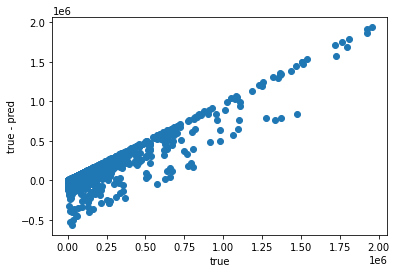

In [ ]:
plt.scatter(test_y_true.numpy(), (test_y_true-test_y_pred).numpy())
plt.xlabel("true")
plt.ylabel("true - pred")
plt.show()

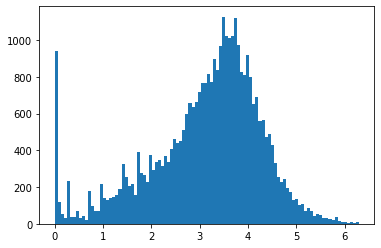

In [ ]:
plt.hist(np.log10(test_y_true), bins=100)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


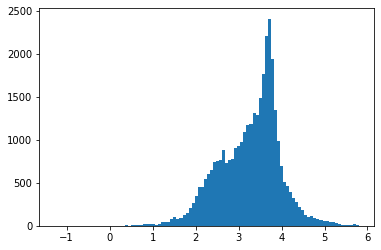

In [ ]:
plt.hist(np.log10(test_y_pred), bins=100)
plt.show()

In [ ]:
test_X.iloc[np.where(test_y_true-test_y_pred>1.75*1e6)]

,Launch_Day,duration,n_gifs,n_websites,Deadline_Day,historic_pc2,historic_pc0,historic_pc3,historic_pc4,creator_bio,Deadline_Week,Launch_Week,tiers_values_std,disable_communication,has_video,category_pledged,category_odds,country_pledged,country_odds,sub_category_pledged,sub_category_odds,lang_pledged,lang_odds
67302,24,2592000,0.0,3.0,24,0.477106,0.004546,0.415513,0.289029,466,3,1,152.573130,False,True,21737.140685,0.998547,15595.118156,0.660655,24073.822614,1.000000,15059.324321,0.654071
139046,9,2588400,0.0,1.0,8,0.000000,0.000000,0.000000,0.000000,264,5,3,138.468994,False,False,11149.782030,0.845108,15595.118156,0.660655,14442.216708,0.642424,15059.324321,0.654071
85590,12,2592000,0.0,2.0,11,0.000000,0.000000,0.000000,0.000000,153,6,4,6.964194,False,True,5298.860192,0.997655,15595.118156,0.660655,0.000000,0.000000,15059.324321,0.654071
189737,3,2592000,0.0,1.0,3,0.000000,0.000000,0.000000,0.000000,362,5,3,149.849706,False,True,21737.140685,0.998547,15595.118156,0.660655,24073.822614,1.000000,15059.324321,0.654071
